In [1]:
import sys
sys.path.append('./data_prep')
sys.path.append('./models')

In [27]:
from clustering_models import service_type_sep, make_scaled_df, num_of_components, feature_explained_variance,\
                            scree_plot, elbow_method, k_distance_plot, clustering_model, cluster_evaluation, comparison_of_scores_kmeans,\
                            cluster_visualization, cluster_separation, clusters_center, compare_columns, cluster_center_visualize, visualize_service_type, comparison_of_scores_dbscan
from data_preparation import get_data, get_cluster_df, get_regression_df
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50) 

# font_name = fm.FontProperties(fname="/Users/leeseohyun/Library/Fonts/AppleGothic.ttf").get_name()
# mpl.rc('font', family=font_name)
plt.rcParams["axes.unicode_minus"] = False

In [6]:
''' 
# 전처리된 데이터 불러오기 

cnx = pymysql.connect(user='mt-1', password='1111', host='ec2-15-152-249-56.ap-northeast-3.compute.amazonaws.com', database='zigbang_project')
query = 'SELECT * FROM zigbang_project.zb_final_cluster;'
df = pd.read_sql(query, cnx)
cnx.close()
'''

# 군집분석에 맞는 전처리된 데이터 불러오기 
clustering_df = get_cluster_df()

clustering_df.shape

(34229, 47)

## 데이터 스케일링 
- 원핫인코딩 & 0/1값만 있는 (이진) 컬럼들을 제외한 피쳐들 스케일링 필요 
- 스케일링 필요한 피쳐 (29/47) 

In [28]:
non_binary_columns = [col for col in clustering_df.columns if set(clustering_df[col].unique()) not in [{0, 1}, {0}, {1}]]
non_binary_df = clustering_df[non_binary_columns]

In [33]:
print(non_binary_df.columns)
print(non_binary_df.shape)

Index(['_floor', 'size_m2', 'manage_cost_count', 'near_subways_count',
       'options_count', 'supermarket_dist', 'convenience_store_dist',
       'school_dist', 'subway_dist', 'cultural_venue_dist',
       'public_institution_dist', 'hospital_dist', 'building_dandok_p',
       'building_apt_p', 'building_yeonlip_p', 'building_dasedae_p',
       'building_nonresidential_p', 'building_others_p', 'gender_ratio',
       'ppltn_foreign_domestic_ratio', 'ppltn_dnsty', 'corp_to_pop',
       'ppltn_adult_p', 'hhd_collective_p', 'hhd_private_p', 'hhd_family_p',
       'hhd_alone_p', 'safety_idx', 'rent_adjusted'],
      dtype='object')
(34229, 29)


In [34]:
non_binary_df.describe()

,_floor,size_m2,manage_cost_count,near_subways_count,options_count,supermarket_dist,convenience_store_dist,school_dist,subway_dist,cultural_venue_dist,public_institution_dist,hospital_dist,building_dandok_p,building_apt_p,building_yeonlip_p,building_dasedae_p,building_nonresidential_p,building_others_p,gender_ratio,ppltn_foreign_domestic_ratio,ppltn_dnsty,corp_to_pop,ppltn_adult_p,hhd_collective_p,hhd_private_p,hhd_family_p,hhd_alone_p,safety_idx,rent_adjusted
count,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.00000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000,34229.000000
mean,6.219521,30.060105,1.544860,2.475679,5.829443,1302.414035,128.723480,497.078355,917.716089,3317.06512,582.044845,551.670484,0.125337,0.545291,0.037756,0.278647,0.012943,0.168113,1.020719,0.087385,15883.048111,0.162970,0.699033,0.000675,0.942781,0.390408,0.378503,1.602355,73.709090
std,6.649505,15.040351,1.368398,1.544129,3.393104,1023.938633,100.912938,294.846767,1067.130791,3369.10923,415.186602,380.691605,0.110506,0.286312,0.040762,0.218672,0.011454,0.267020,0.133598,0.162153,10961.784613,0.240833,0.072688,0.000819,0.078219,0.138999,0.125333,0.736545,44.649541
min,1.000000,2.780000,0.000000,0.000000,0.000000,10.000000,0.000000,8.000000,5.000000,24.00000,4.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.623000,0.003000,91.600000,0.026000,0.134000,0.000000,0.226000,0.054000,0.077000,0.000000,10.333000
25%,2.000000,19.830000,0.000000,1.000000,5.000000,656.000000,61.000000,305.000000,374.000000,1178.00000,333.000000,314.000000,0.042000,0.300000,0.009000,0.079000,0.005000,0.029000,0.939000,0.020000,6904.800000,0.078000,0.683000,0.000000,0.938000,0.298000,0.292000,1.000000,45.683000
50%,3.000000,26.020000,2.000000,3.000000,7.000000,1075.000000,98.000000,474.000000,583.000000,2191.00000,522.000000,502.000000,0.099000,0.554000,0.028000,0.248000,0.011000,0.069000,0.988000,0.036000,13829.800000,0.104000,0.709000,0.001000,0.970000,0.400000,0.360000,2.000000,61.250000
75%,8.000000,33.750000,3.000000,4.000000,8.000000,1660.000000,164.000000,641.000000,996.000000,3957.00000,734.000000,706.000000,0.183000,0.800000,0.054000,0.437000,0.018000,0.207000,1.066000,0.083000,23876.700000,0.160000,0.738000,0.001000,0.984000,0.490000,0.465000,2.000000,88.167000
max,51.000000,280.930000,5.000000,7.000000,12.000000,14268.000000,1639.000000,4037.000000,17040.000000,27603.00000,4278.000000,4706.000000,0.931000,1.000000,0.645000,0.888000,0.135000,2.826000,2.455000,4.340000,49681.100000,5.672000,0.829000,0.010000,0.998000,0.731000,0.738000,4.000000,633.333000


### 분포 확인 & 정규성 검정 
- 분포 확인: 대부분 오른쪽 꼬리가 아주 길다 
- D'Agostino & Pearson's Test: 왜도(skew) / 첨도(kurtosis)를 결합하여 종합적인 정규성 검정을 실행했으나 정규분포를 따르는 변수가 아예 없다. 

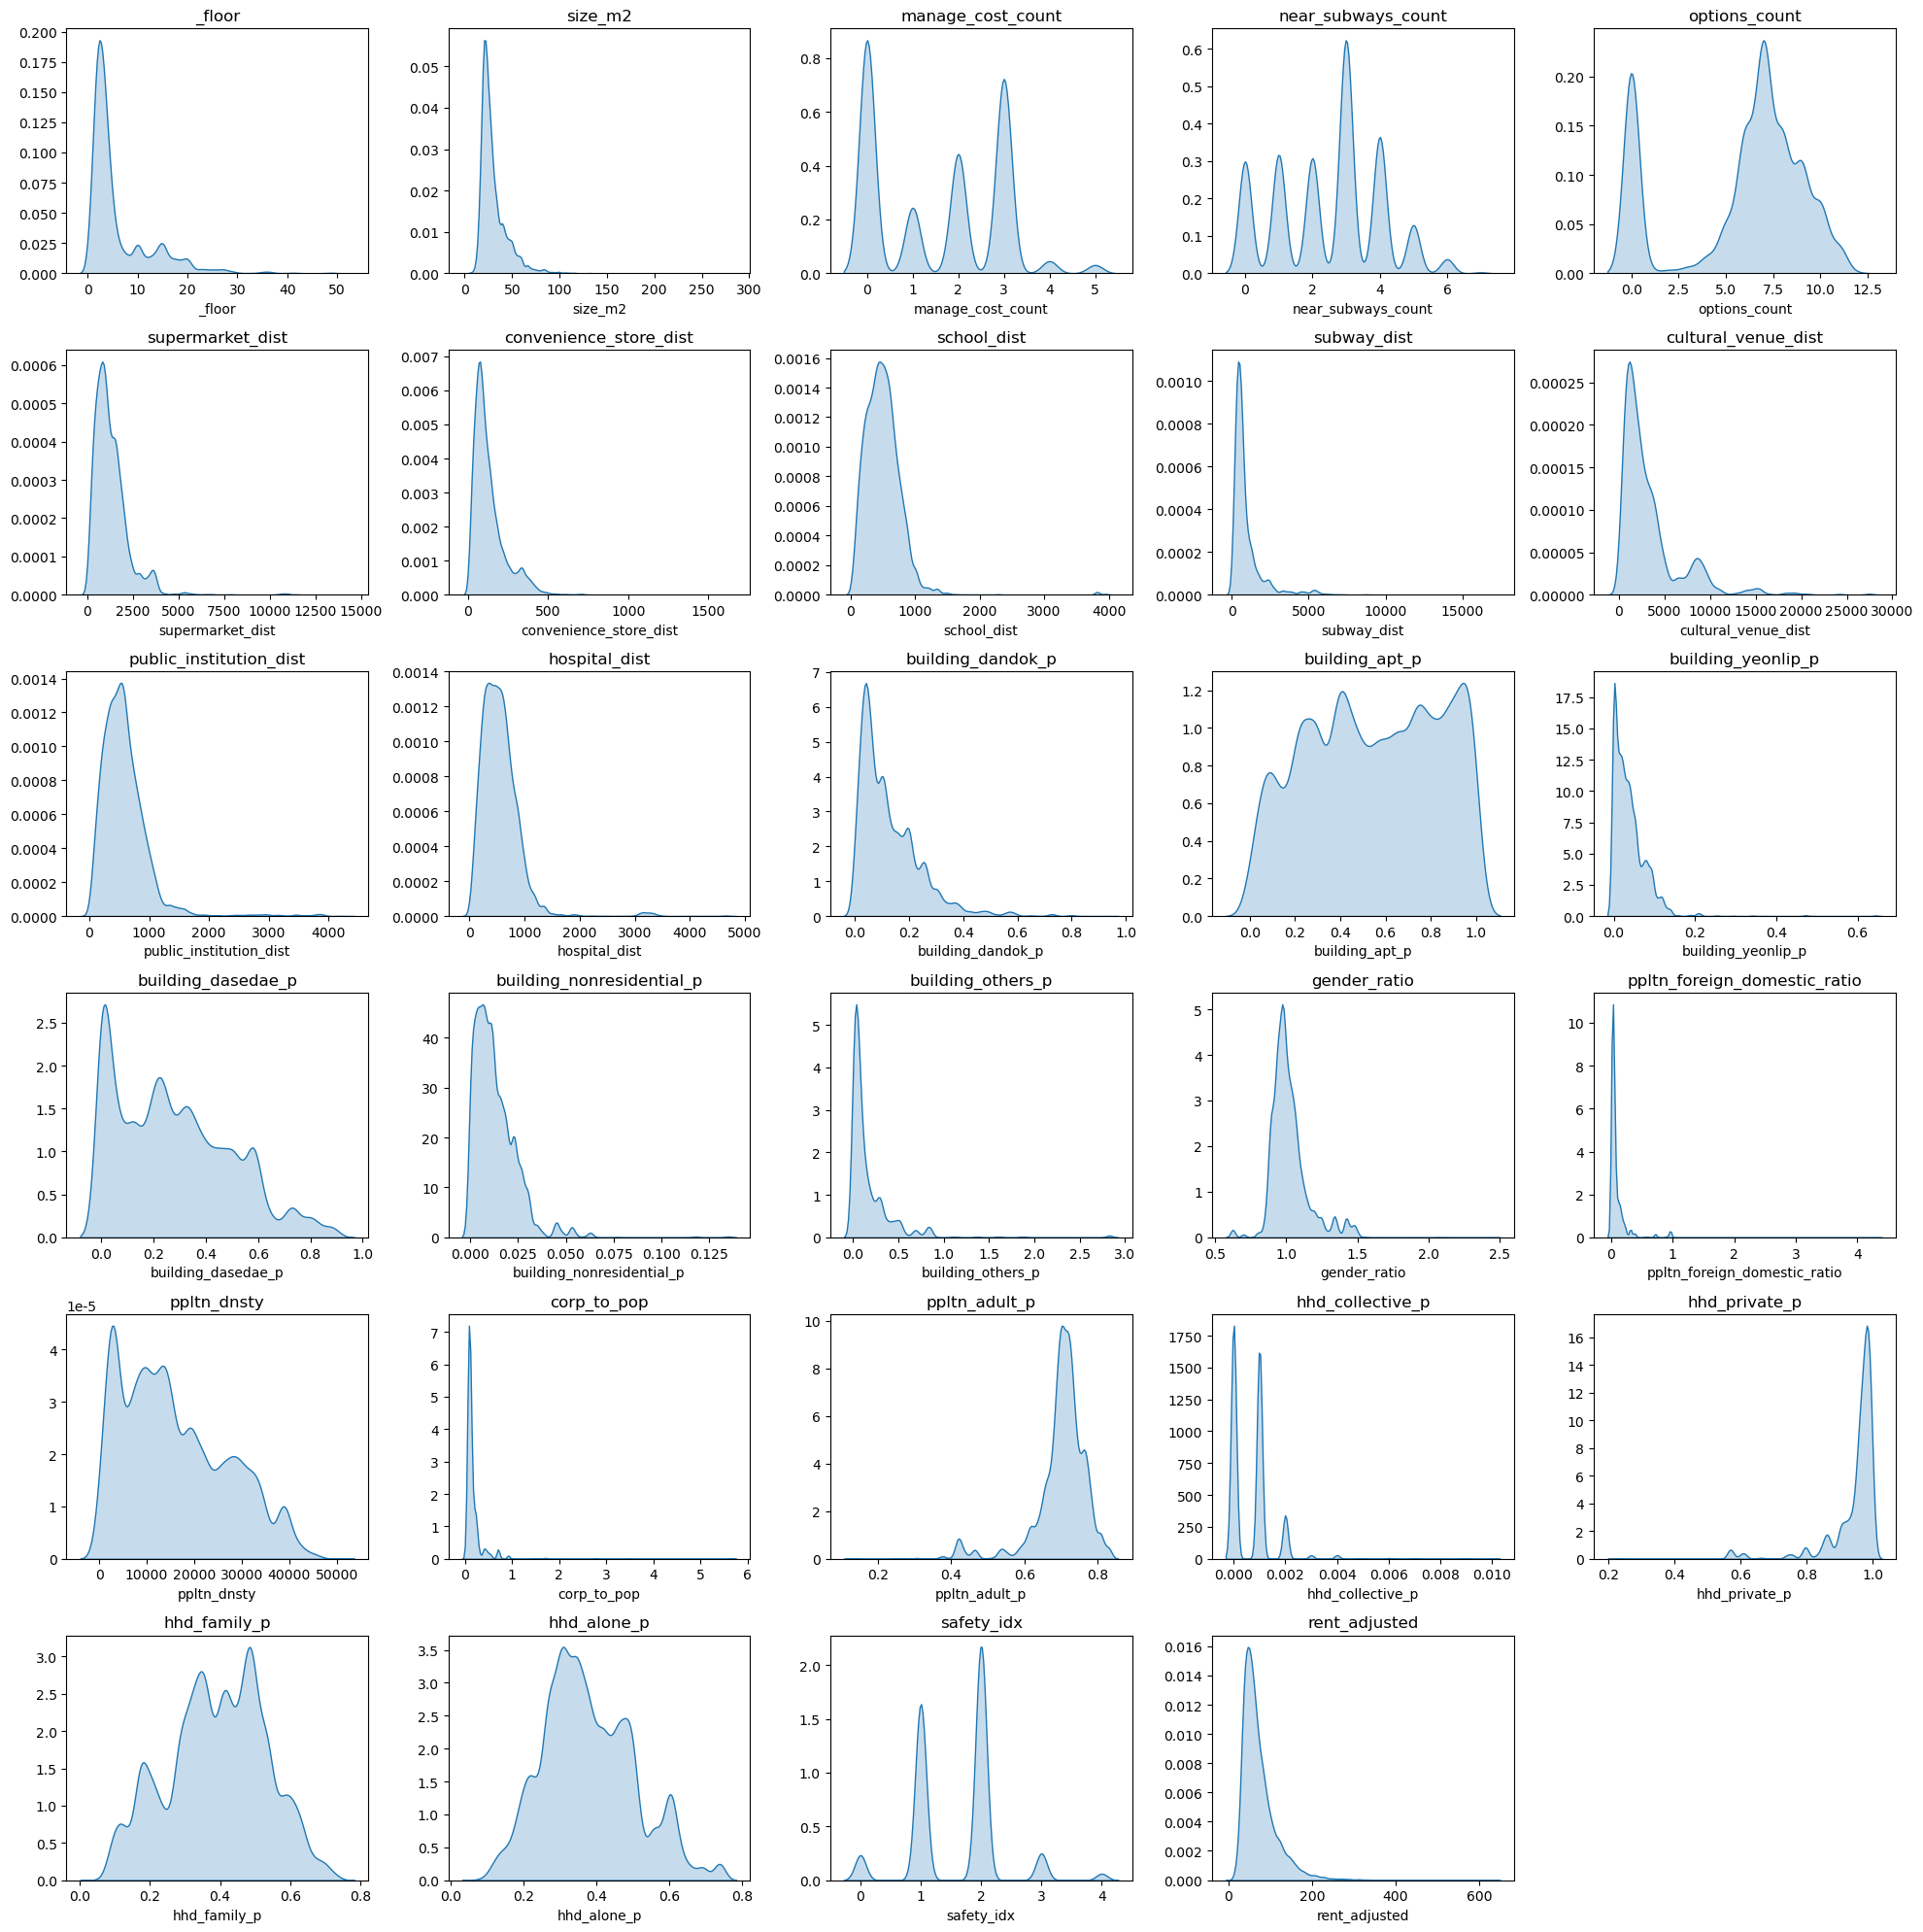

In [37]:
fig, ax = plt.subplots(6, 5, figsize=(20, 20))
ax = ax.ravel()

for i, col in enumerate(non_binary_df.columns):
    sns.kdeplot(non_binary_df[col], ax=ax[i], fill=True)  
    ax[i].set_title(col)
    ax[i].set_ylabel('')

for j in range(29, 30):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [59]:
from scipy.stats import normaltest

results = {}

for col in non_binary_df.columns:
    stat, p = normaltest(non_binary_df[col])
    results[col] = p

for column, p_value in results.items():
    if p_value > 0.05:
        print(f"{column} seems to follow a Gaussian distribution (p={p_value:.5f})")
    else:
        print(f"{column} does not seem to follow a Gaussian distribution (p={p_value:.5f})")

_floor does not seem to follow a Gaussian distribution (p=0.00000)
size_m2 does not seem to follow a Gaussian distribution (p=0.00000)
manage_cost_count does not seem to follow a Gaussian distribution (p=0.00000)
near_subways_count does not seem to follow a Gaussian distribution (p=0.00000)
options_count does not seem to follow a Gaussian distribution (p=0.00000)
supermarket_dist does not seem to follow a Gaussian distribution (p=0.00000)
convenience_store_dist does not seem to follow a Gaussian distribution (p=0.00000)
school_dist does not seem to follow a Gaussian distribution (p=0.00000)
subway_dist does not seem to follow a Gaussian distribution (p=0.00000)
cultural_venue_dist does not seem to follow a Gaussian distribution (p=0.00000)
public_institution_dist does not seem to follow a Gaussian distribution (p=0.00000)
hospital_dist does not seem to follow a Gaussian distribution (p=0.00000)
building_dandok_p does not seem to follow a Gaussian distribution (p=0.00000)
building_apt_p

### 박스플롯 확인 
- 데이터셋에 이상치가 너무 많다는 걸 확인할 수 있다 

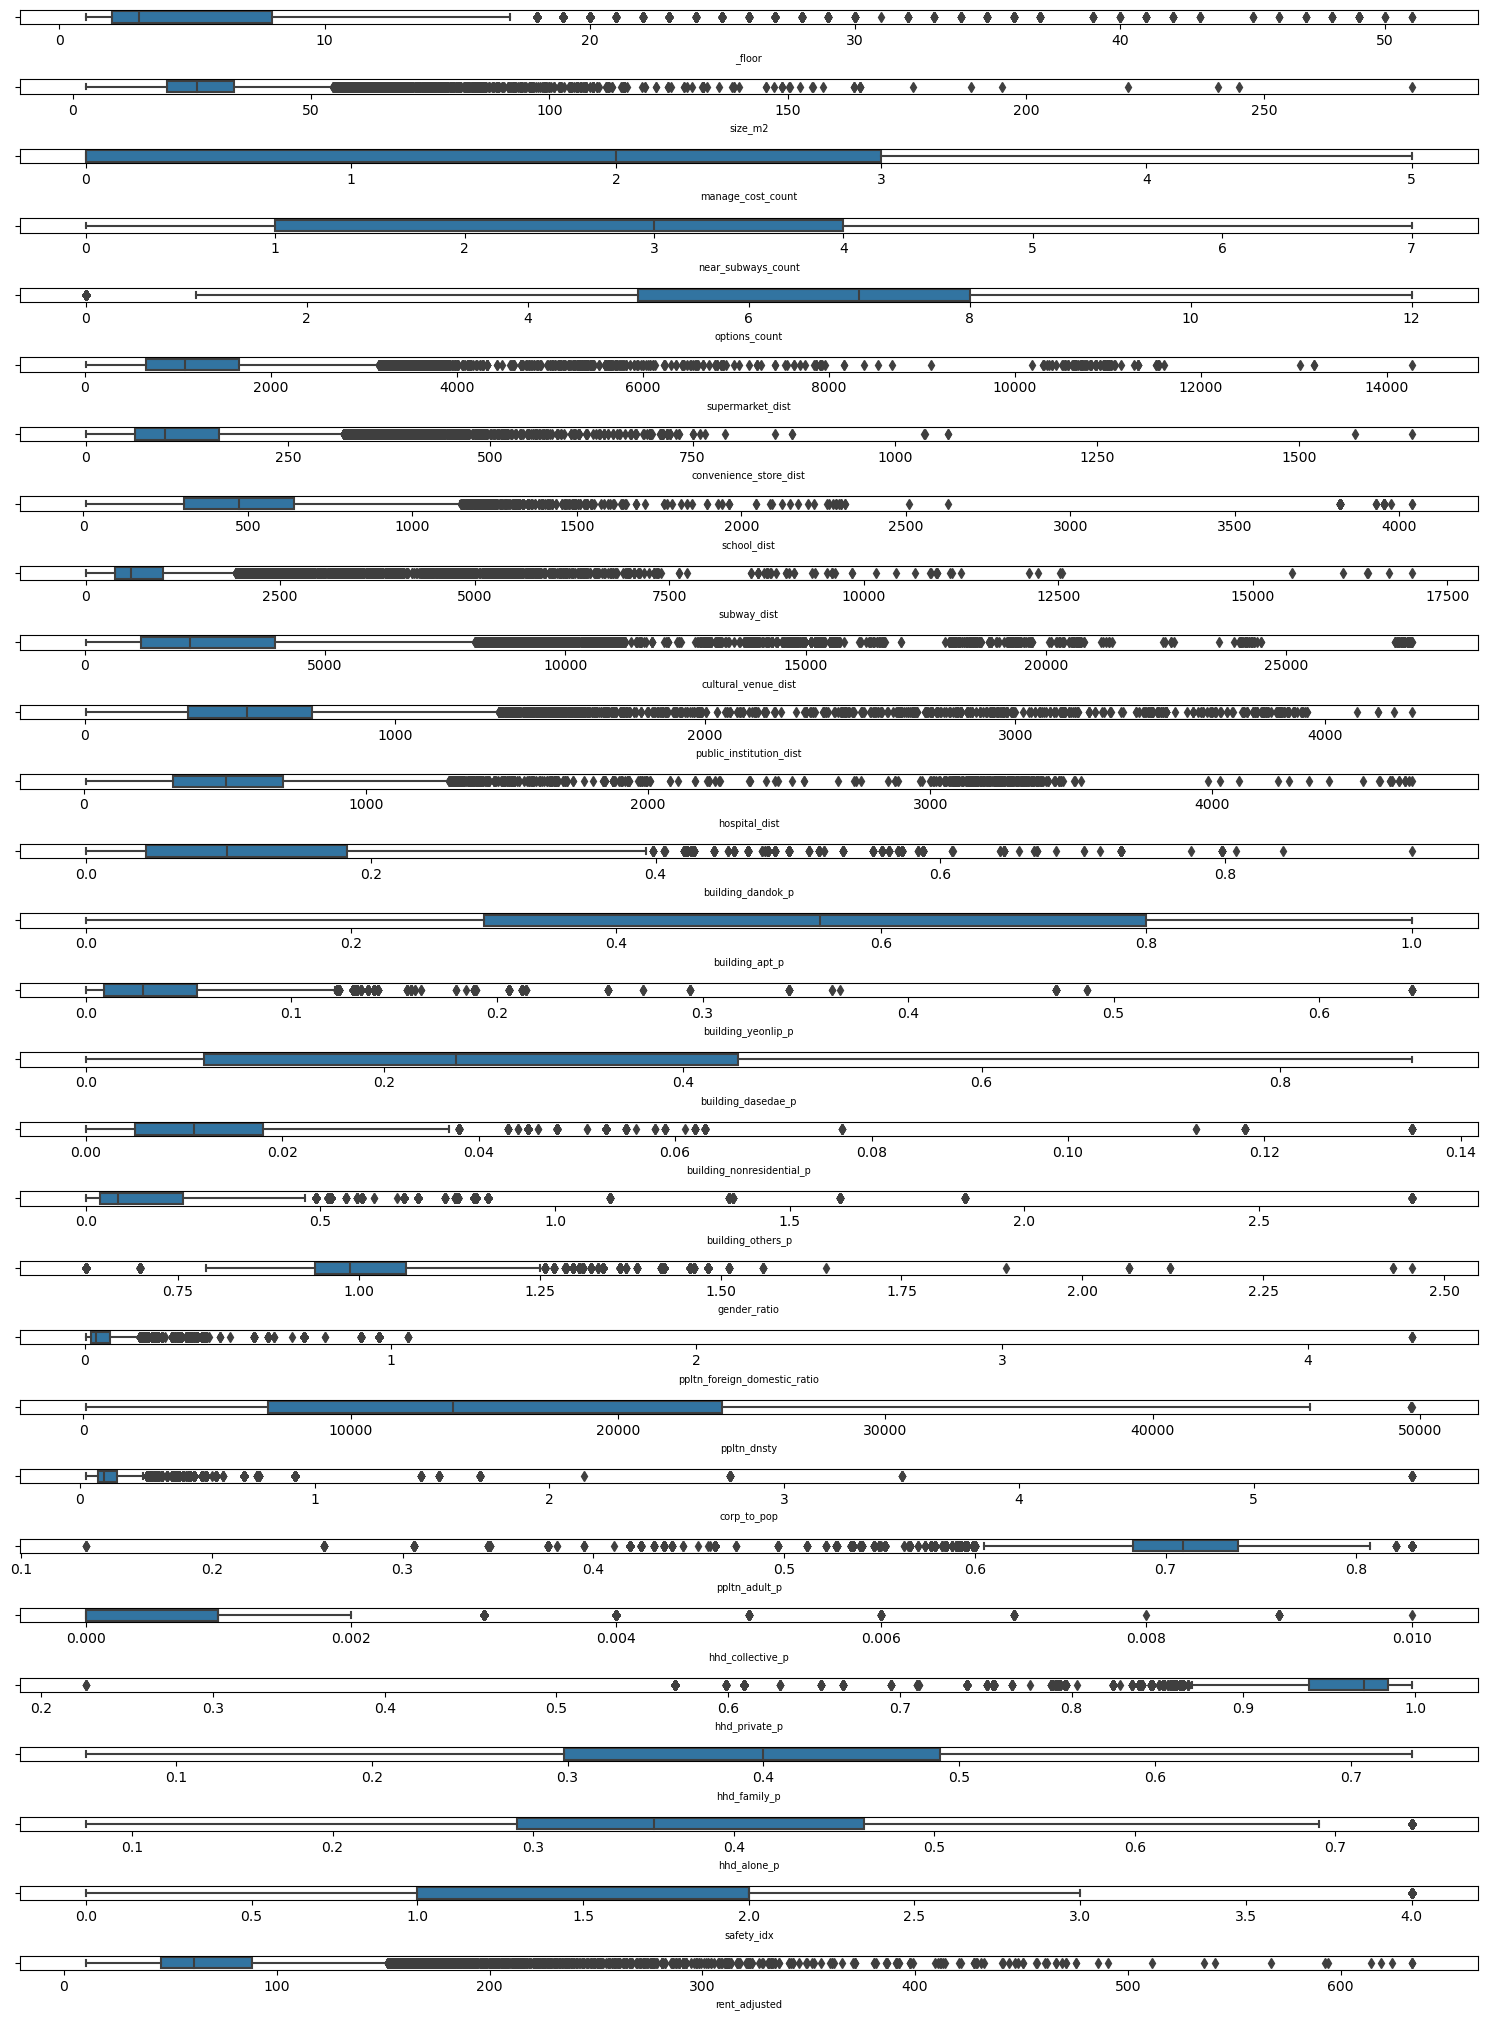

In [57]:
n = len(non_binary_df.columns)

plt.figure(figsize=(15, 0.7  * n))  

for i, col in enumerate(non_binary_df.columns, 1):
    ax = plt.subplot(n, 1, i)  
    sns.boxplot(x=non_binary_df[col])
    ax.set_xlabel(col, fontsize=7) 

plt.tight_layout()
plt.show()

## 스케일링 결론 
1. 데이터가 정규분포를 따르지 않는다 
   - Standard Scaling 적합하지 않다 
2. 이상치의 존재 
   - 대이터 내에서 이상치의 수가 많이 관찰됨 
   - 이러한 특성 때문에 MinMax Scaling은 이상치에 크게 영향을 받을 수 있으므로 적합하지 않다 

로버스트 스케일링
- 이상치의 영향을 크게 받지 않기 위해 설계되었다 
  - 중앙값과 사분위수 범위(IQR)를 활용하여 데이터를 스케일링
  - 따라서 이상치의 영향을 상대적으로 덜 받게 된다 

<b>종합적으로 로버스트 스케일링이 해당 데이터에 가장 적합하다는 결론을 내림</b>

# 요기까지

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standard_scaled = pd.DataFrame(scaler.fit_transform(clustering_df), columns=clustering_df.columns)

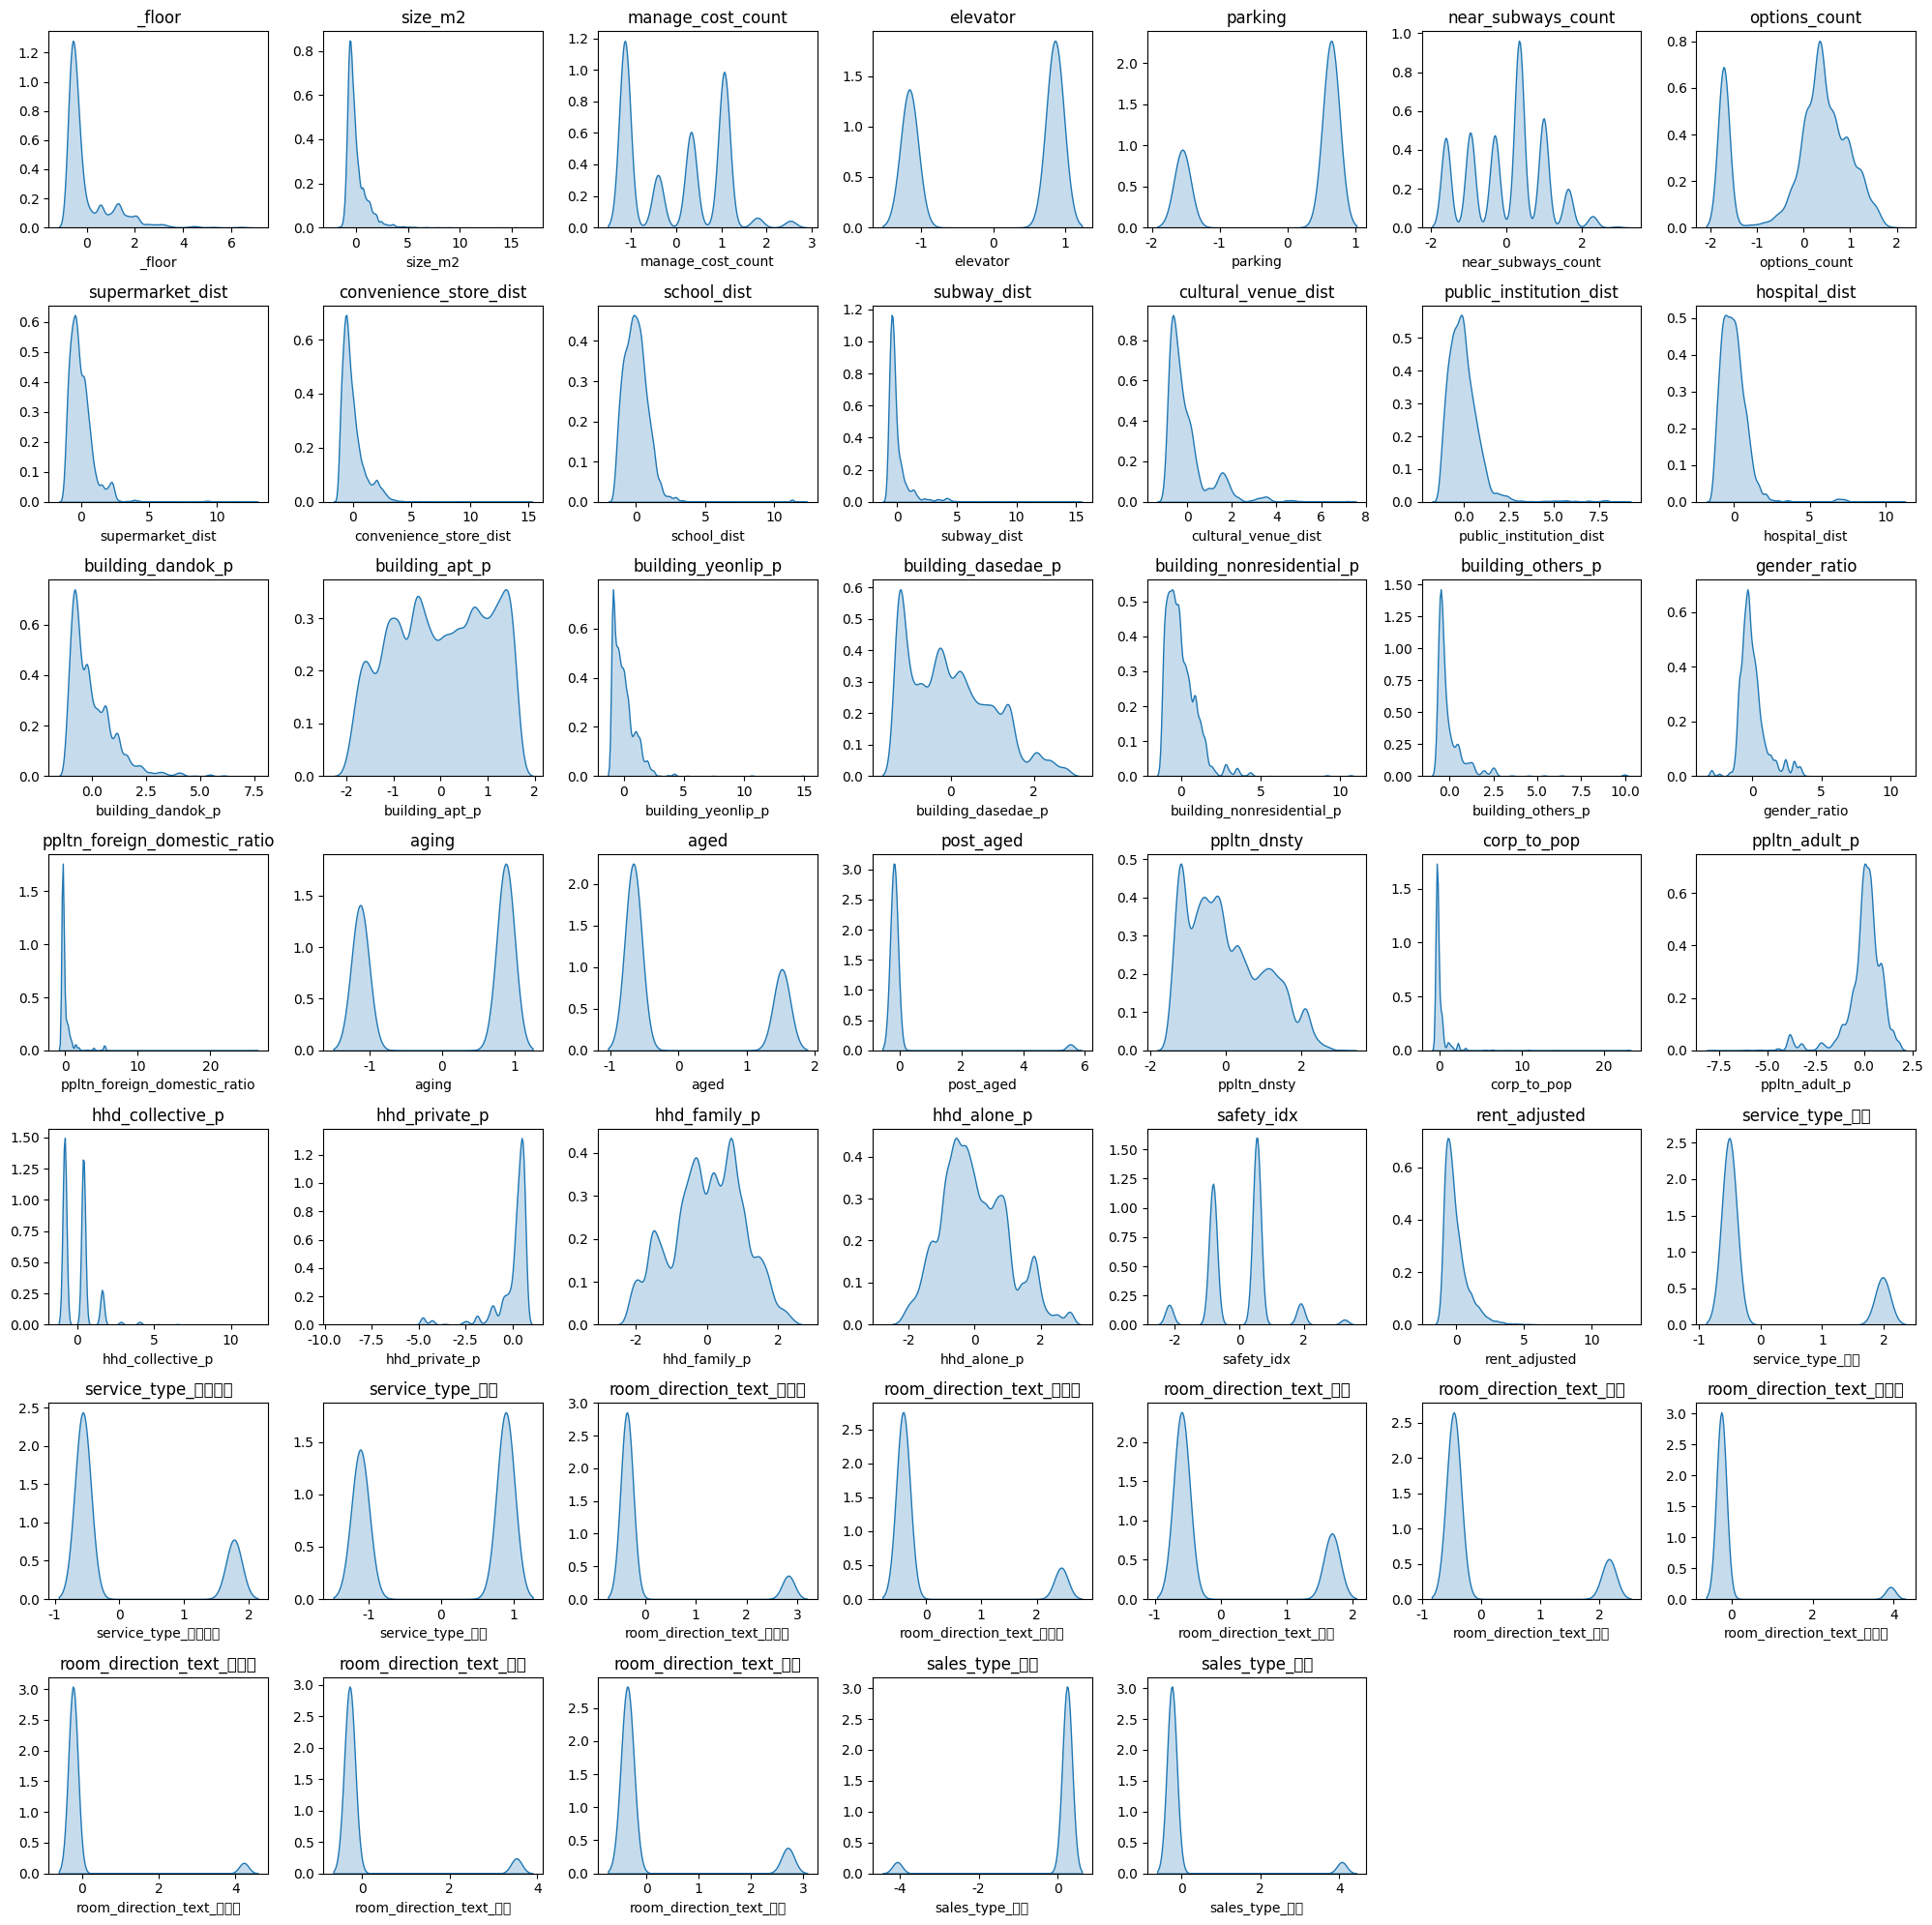

In [11]:
fig, ax = plt.subplots(7, 7, figsize=(20, 20))
ax = ax.ravel()

for i, col in enumerate(standard_scaled.columns):
    sns.kdeplot(standard_scaled[col], ax=ax[i], fill=True)  
    ax[i].set_title(col)
    ax[i].set_ylabel('')

for j in range(47, 49):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

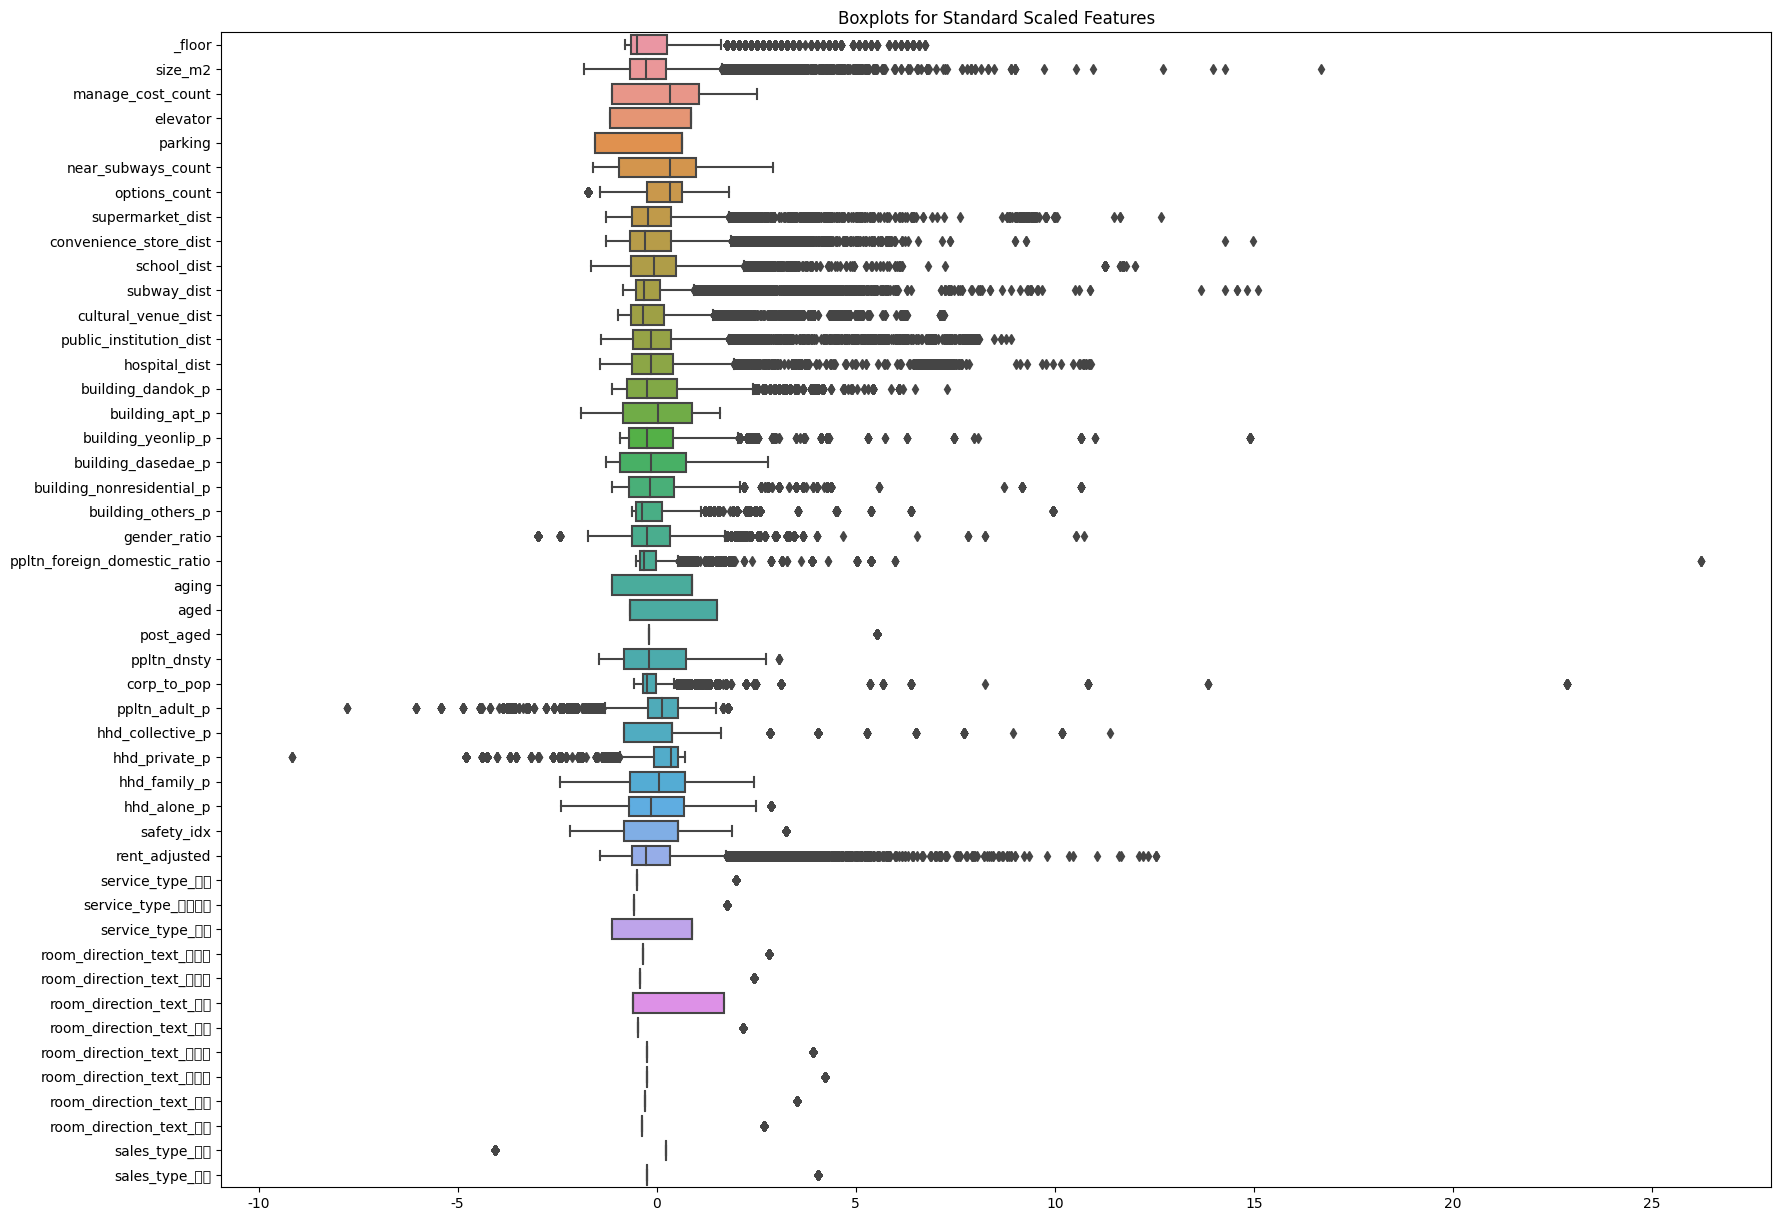

In [15]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=standard_scaled, orient="h") 
plt.title("Boxplots for Standard Scaled Features")
plt.show()

In [13]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
robust_scaled = pd.DataFrame(scaler.fit_transform(clustering_df), columns=clustering_df.columns)

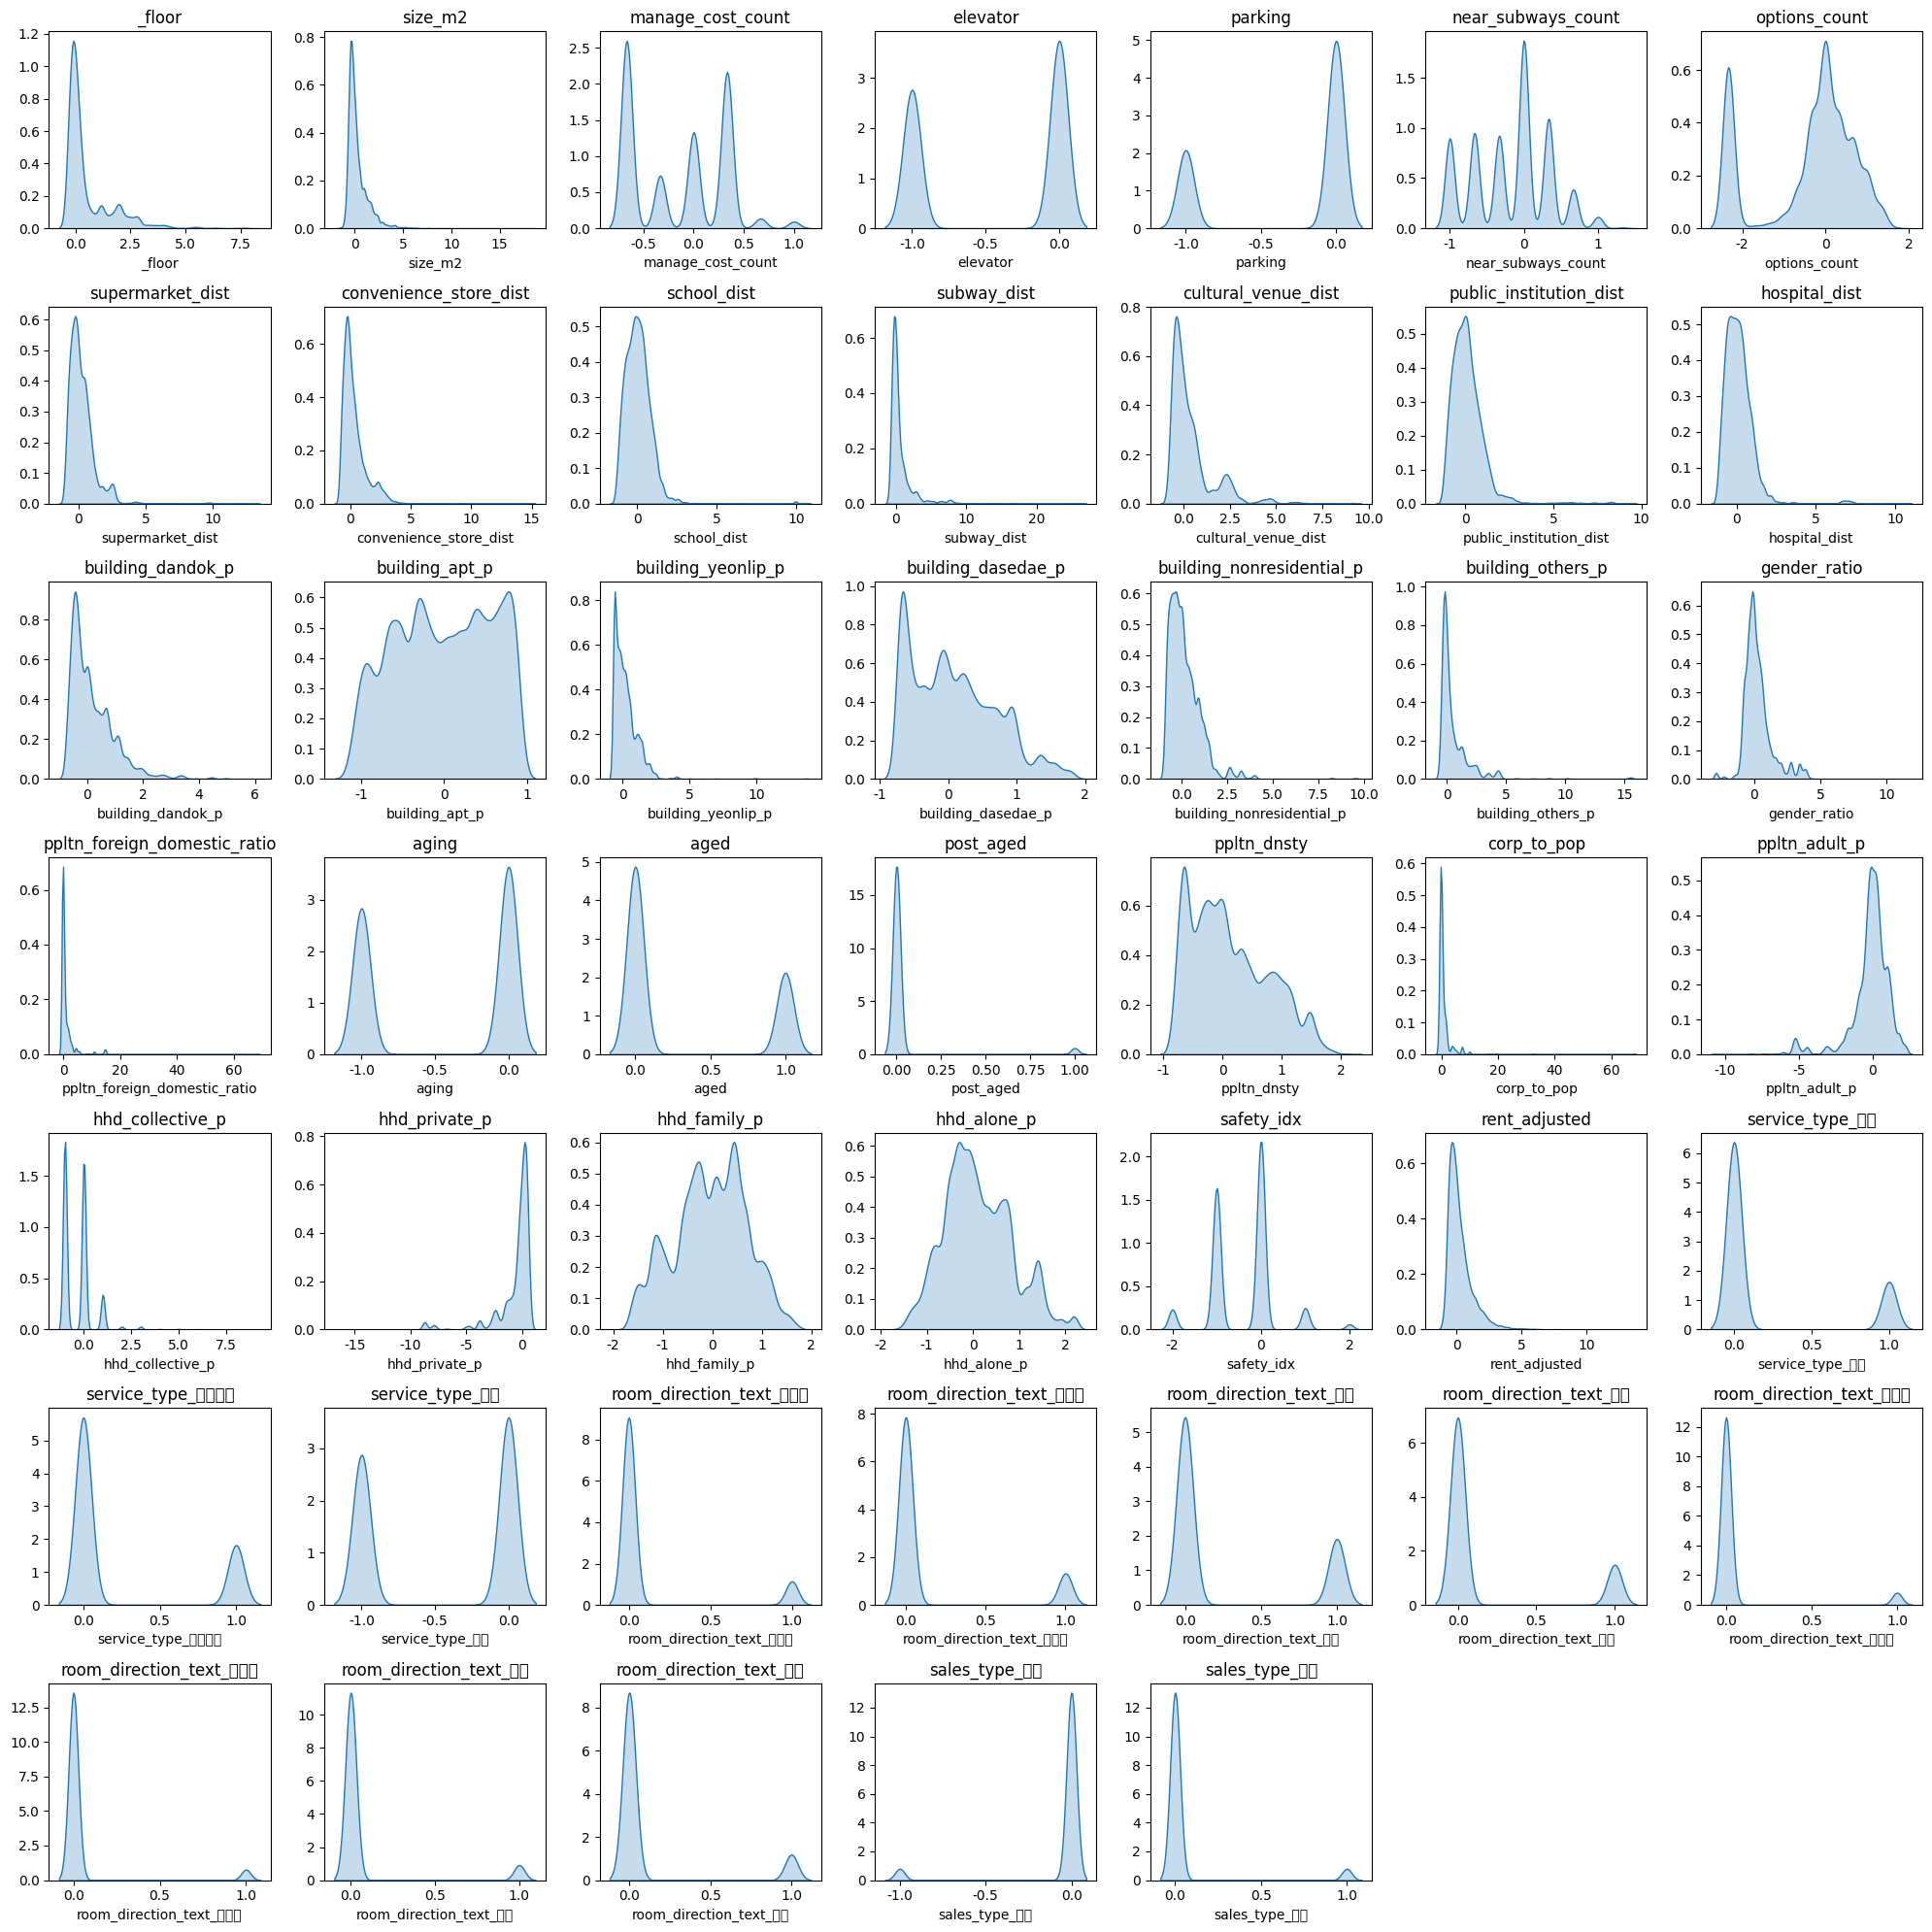

In [14]:
fig, ax = plt.subplots(7, 7, figsize=(20, 20))
ax = ax.ravel()

for i, col in enumerate(robust_scaled.columns):
    sns.kdeplot(robust_scaled[col], ax=ax[i], fill=True)  
    ax[i].set_title(col)
    ax[i].set_ylabel('')

for j in range(47, 49):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

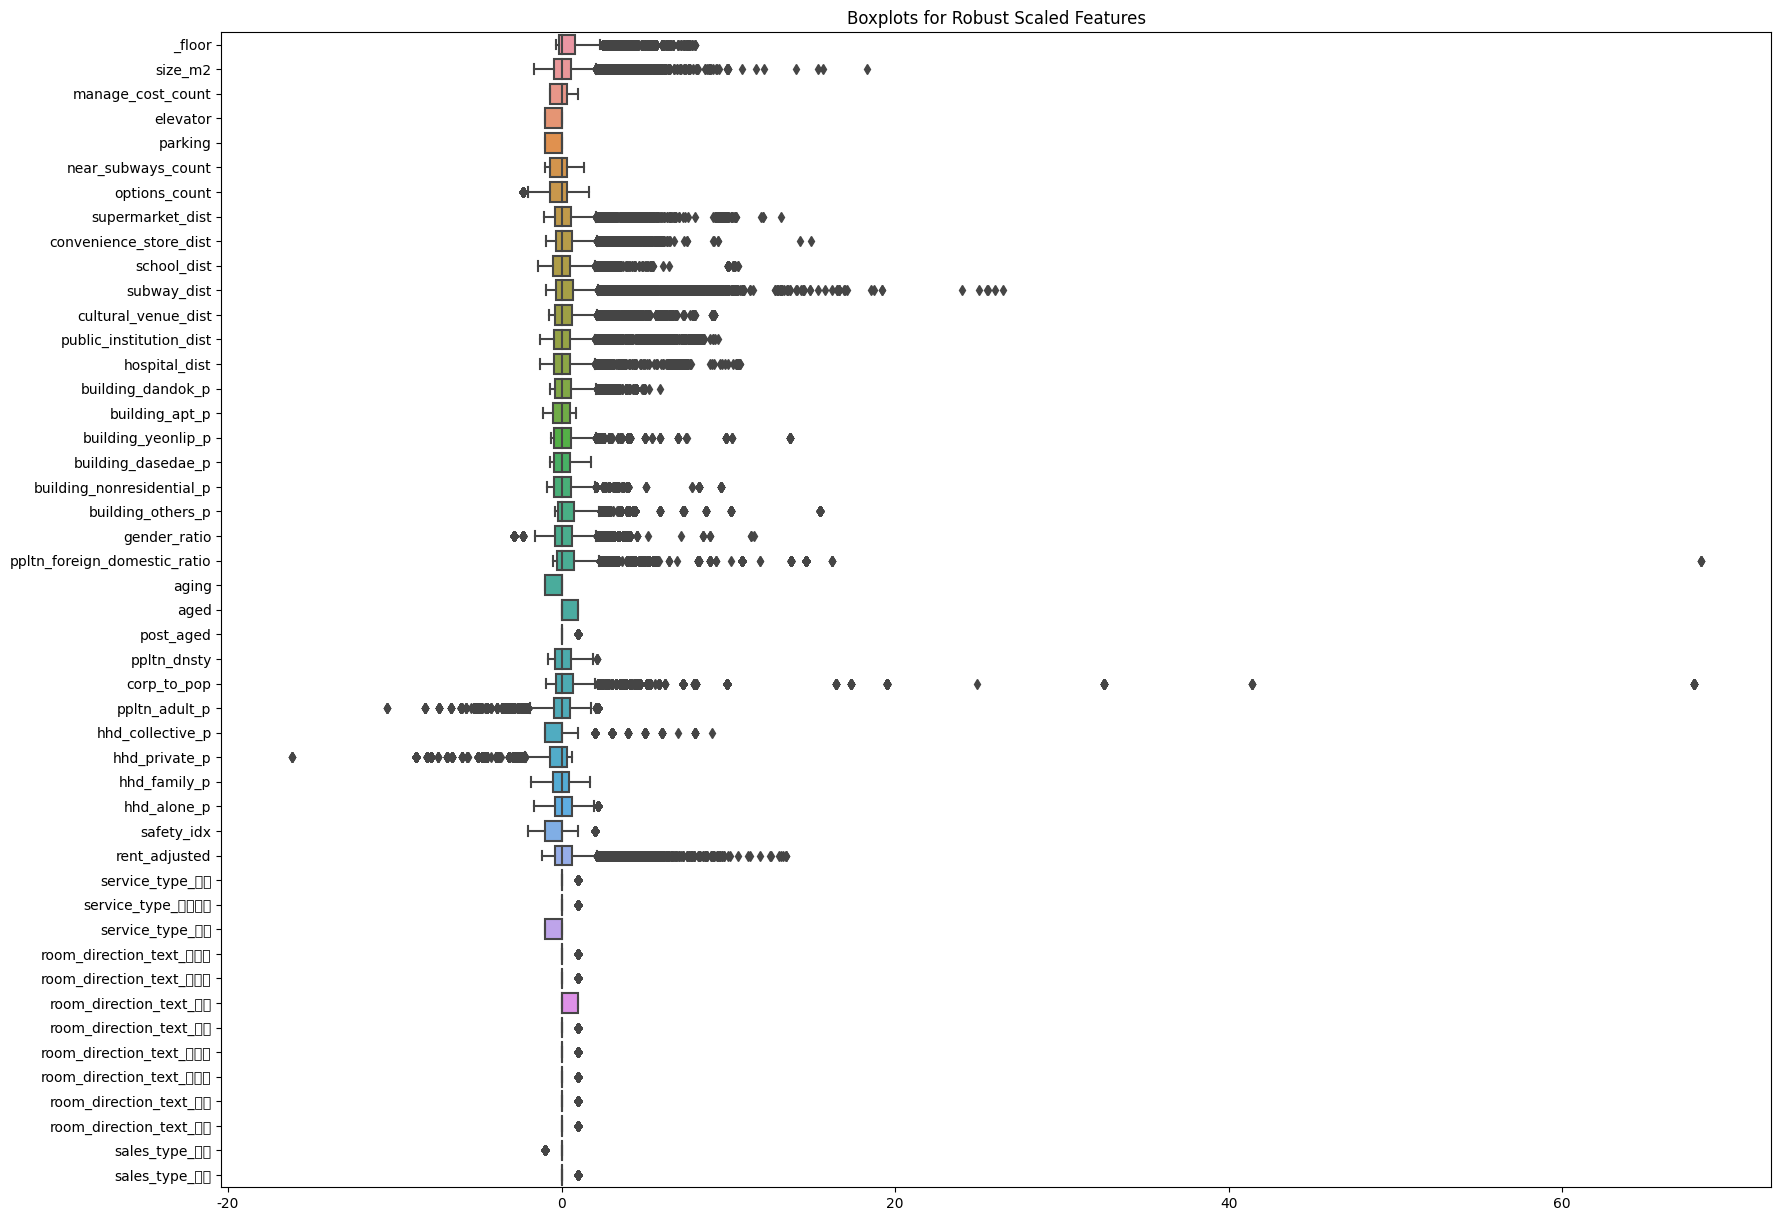

In [16]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=robust_scaled, orient="h") 
plt.title("Boxplots for Robust Scaled Features")
plt.show()